# Preprocess

Paths to datasets


In [ ]:
dataset_path = '/home/gsalsabil2/dl_kapel/lol_dataset'
raw_train_path = f'{dataset_path}/our485'
test_path = f'{dataset_path}/eval15'

In [ ]:
class LOLDataset(Dataset):
    def __init__(self, root_dir, input_transform=None, target_transform=None):
        self.root_dir = root_dir
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.low_dir = os.path.join(root_dir, "low")
        self.high_dir = os.path.join(root_dir, "high")
        self.image_names = sorted(os.listdir(self.low_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        low_img_path = os.path.join(self.low_dir, self.image_names[idx])
        high_img_path = os.path.join(self.high_dir, self.image_names[idx])

        low_img = Image.open(low_img_path).convert("RGB")
        high_img = Image.open(high_img_path).convert("RGB")

        if self.input_transform:
            low_img = self.input_transform(low_img)

        if self.target_transform:
            high_img = self.target_transform(high_img)
            
            
        low_filename = os.path.basename(low_img_path)
        high_filename = os.path.basename(high_img_path)
        
        return low_img, high_img, low_filename, high_filename

In [ ]:
class RandomAugment:
    def __init__(self):
        self.color_jitter = transforms.ColorJitter(
            contrast=0.05,
            saturation=0.1,
            hue=0.2
        )
        self.gaussian_blur = transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5))
        # self.to_grayscale = transforms.RandomGrayscale(p=0.3)
        self.invert = transforms.RandomInvert(p=0.3)
        
    def __call__(self, img):
        # Apply augmentations in random order
        aug_order = random.sample(['color', 'blur', 'invert'], k=random.randint(0, 3))
        
        for aug in aug_order:
            if aug == 'color' and random.random() < 0.7:  # 70% chance
                img = self.color_jitter(img)
            elif aug == 'blur' and random.random() < 0.5:  # 50% chance
                img = self.gaussian_blur(img)
            elif aug == 'invert':
                img = self.invert(img)
                
        return img

# Usage in Dataset
transform = transforms.Compose([
    RandomAugment(),  # Your custom augmentations
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
])

# Transform Pipelines
train_input_transform = transforms.Compose([
    RandomAugment(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [ ]:
low_path = os.path.join(raw_train_path, "low")
high_path = os.path.join(raw_train_path, "high")

# Load all image paths
pairs = [(os.path.join(low_path, f), os.path.join(high_path, f)) 
         for f in os.listdir(low_path) if f.endswith('.png')]

print(len(pairs), pairs)
train_size = int(0.8 * len(pairs))
train_pairs, val_pairs = train_test_split(pairs, test_size=0.2, random_state=42)

train_low_paths, train_high_paths = zip(*train_pairs)
val_low_paths, val_high_paths = zip(*val_pairs)

# Convert to lists (Python 3 compatibility)
train_low_paths, train_high_paths = list(train_low_paths), list(train_high_paths)
val_low_paths, val_high_paths = list(val_low_paths), list(val_high_paths)

485 [('/home/gsalsabil2/dl_kapel/lol_dataset/our485/low/96.png', '/home/gsalsabil2/dl_kapel/lol_dataset/our485/high/96.png'), ('/home/gsalsabil2/dl_kapel/lol_dataset/our485/low/579.png', '/home/gsalsabil2/dl_kapel/lol_dataset/our485/high/579.png'), ('/home/gsalsabil2/dl_kapel/lol_dataset/our485/low/701.png', '/home/gsalsabil2/dl_kapel/lol_dataset/our485/high/701.png'), ('/home/gsalsabil2/dl_kapel/lol_dataset/our485/low/91.png', '/home/gsalsabil2/dl_kapel/lol_dataset/our485/high/91.png'), ('/home/gsalsabil2/dl_kapel/lol_dataset/our485/low/757.png', '/home/gsalsabil2/dl_kapel/lol_dataset/our485/high/757.png'), ('/home/gsalsabil2/dl_kapel/lol_dataset/our485/low/25.png', '/home/gsalsabil2/dl_kapel/lol_dataset/our485/high/25.png'), ('/home/gsalsabil2/dl_kapel/lol_dataset/our485/low/62.png', '/home/gsalsabil2/dl_kapel/lol_dataset/our485/high/62.png'), ('/home/gsalsabil2/dl_kapel/lol_dataset/our485/low/617.png', '/home/gsalsabil2/dl_kapel/lol_dataset/our485/high/617.png'), ('/home/gsalsabil2/

In [ ]:
class PairedDataset(Dataset):
    def __init__(self, low_paths, high_paths,  low_transform=None, high_transform=None):
        self.low_paths = low_paths
        self.high_paths = high_paths
        self.low_transform = low_transform
        self.high_transform = high_transform

    def __len__(self):
        return len(self.low_paths)

    def __getitem__(self, index):
        low_img = Image.open(self.low_paths[index]).convert("RGB")
        high_img = Image.open(self.high_paths[index]).convert("RGB")

        if self.low_transform:
            low_img = self.low_transform(low_img)
        if self.high_transform:
            high_img = self.high_transform(high_img)

        low_filename = os.path.basename(self.low_paths[index])
        high_filename = os.path.basename(self.high_paths[index])
        
        return low_img, high_img, low_filename, high_filename

# Create dataset instances
train_dataset = PairedDataset(train_low_paths, train_high_paths, low_transform=train_input_transform, high_transform=target_transform)  # Add any transforms if needed
val_dataset = PairedDataset(val_low_paths, val_high_paths, low_transform=target_transform, high_transform=target_transform)  # Add any transforms if needed

test_dataset = LOLDataset(
    root_dir=test_path,
    input_transform=target_transform,
    target_transform=target_transform
)

### DataLoaders


In [ ]:
from torch.utils.data import DataLoader

batch_size = 8

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True   # Speeds up transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,         # No need for validation
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,       # Often use batch_size=1 for testing
    shuffle=False,
    num_workers=1
)

In [ ]:
def show_true_images(low_batch, high_batch, n=4):

    """
    Shows EXACTLY what's in your dataset with correct color handling.
    Works for both normalized and unnormalized images.
    """

    plt.figure(figsize=(18, 8))

    for i in range(min(n, len(low_batch))):
        # --- Low-light ---
        plt.subplot(2, n, i+1)
        low_img = low_batch[i].permute(1, 2, 0).numpy()

        # Handle normalization if present
        if low_img.min() < 0:  # Likely normalized
            low_img = (low_img * 0.5 + 0.5)  # Reverse imagenet norm

        # Ensure proper image range
        low_img = np.clip(low_img, 0, 1)
        plt.imshow(low_img)
        plt.title(f"Low")
        plt.axis('off')

        # --- Normal-light ---
        plt.subplot(2, n, n+i+1)
        high_img = high_batch[i].permute(1, 2, 0).numpy()

        if high_img.min() < 0:  # Likely normalized
            high_img = (high_img * 0.5 + 0.5)

        high_img = np.clip(high_img, 0, 1)
        plt.imshow(high_img)
        plt.title(f"High")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Low resolution file name: ['553.png', '670.png', '676.png', '176.png', '740.png', '664.png', '154.png', '512.png']
High resolution file name: ['553.png', '670.png', '676.png', '176.png', '740.png', '664.png', '154.png', '512.png']


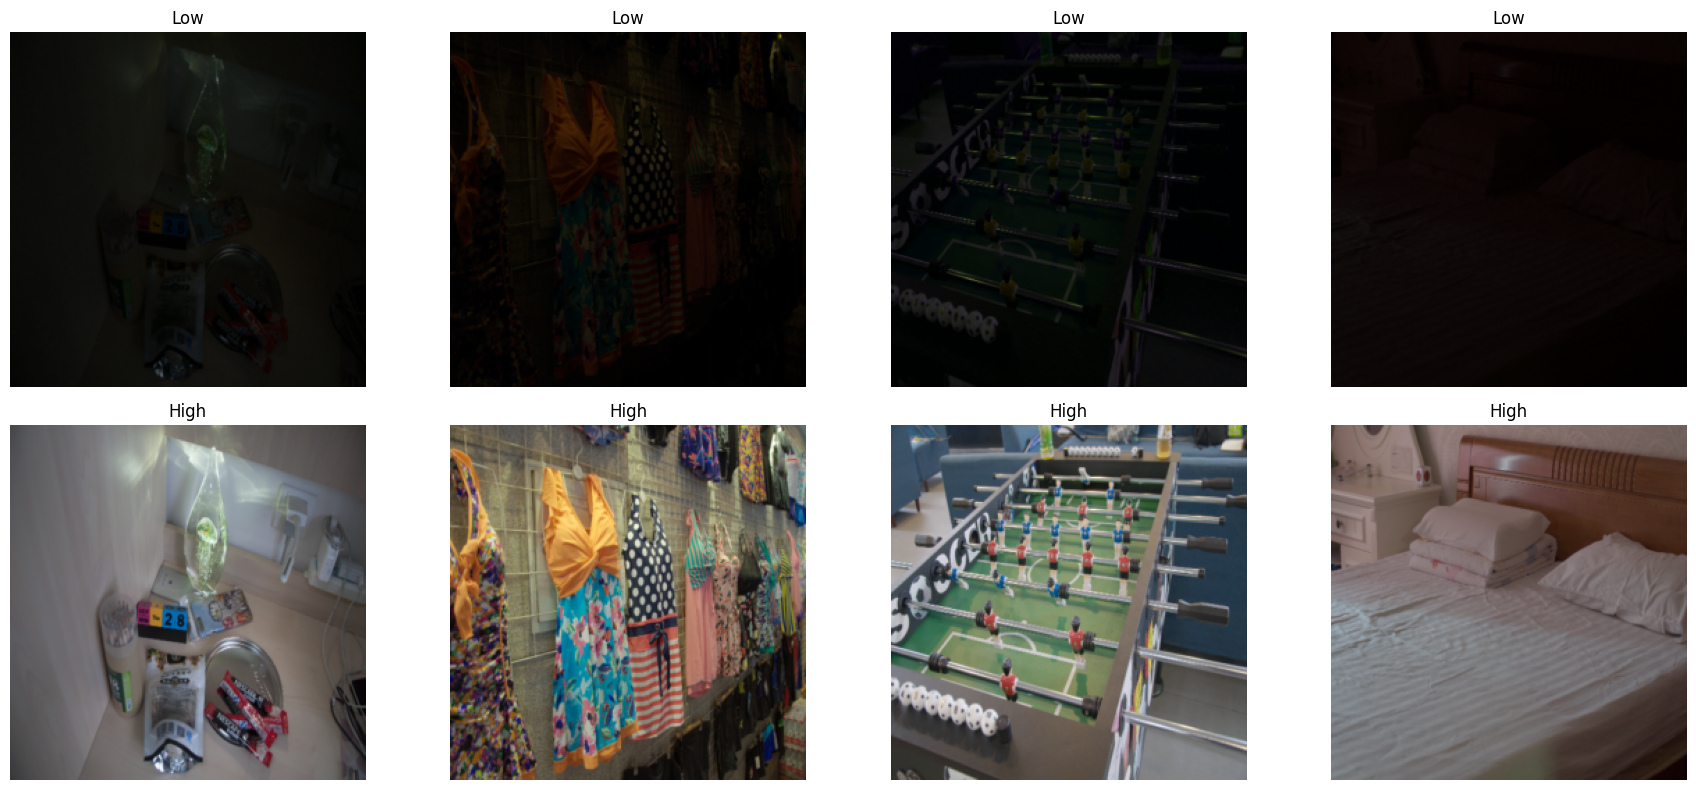

In [ ]:
# Usage
low, high, low_filename, high_filename = next(iter(train_loader))
print("Low resolution file name:", low_filename)
print("High resolution file name:", high_filename)
show_true_images(low, high)

In [ ]:
def save_loader_images(loader, low_dir, high_dir):
    os.makedirs(low_dir, exist_ok=True)
    os.makedirs(high_dir, exist_ok=True)
    
    for batch_idx, (low_imgs, high_imgs, low_filenames, high_filenames) in enumerate(loader):
        for i in range(len(low_imgs)):  # Loop through each image in the batch
            # Get the original filenames
            low_filename = low_filenames[i]
            high_filename = high_filenames[i]
            save_image(low_imgs[i], os.path.join(low_dir, low_filename))
            save_image(high_imgs[i], os.path.join(high_dir, high_filename))

# Usage
save_loader_images(train_loader, "downloaded_images/train/low", "downloaded_images/train/high")
save_loader_images(val_loader, "downloaded_images/val/low", "downloaded_images/val/high")
save_loader_images(test_loader, "downloaded_images/test/low", "downloaded_images/test/high")